In [1]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/nationality.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/passenger-dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air-passengers.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826402 entries, 0 to 1826401
Data columns (total 52 columns):
ANumber                         category
LastName                        category
FirstName                       category
DOB                             category
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  

# By country of citizenship

Define target nationality, check if represented in dataset.

In [3]:
nationality = 'GUATEMALA'

In [4]:
errormsg = f'{nationality} not represented in dataset'
assert nationality.upper() in df['CountryOfCitizenship'].str.upper().unique(), errormsg

Create DataFrames for removals and transfers, removing duplicate `AlienMasterID` values.

In [5]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')

Ranking total removals by `CountryOfCitizenship`. Should implement other comparative statistics.

In [6]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities.drop('index', axis=1, inplace=True)
target = all_nationalities.loc[all_nationalities['CountryOfCitizenship'] == nationality].reset_index()
print(f"{nationality}: ranked {target.loc[0, 'Rank']} of {len(all_nationalities)} countries, with {target.loc[0, 'AlienMasterID']} total removals.")
# Probably a better way to do this than with index

GUATEMALA: ranked 2 of 206 countries, with 350141 total removals.


Create a DataFrame filtered for target nationality only.

In [7]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [8]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

Brownsville South Padre Island International Airport    110796
Phoenix-Mesa-Gateway Airport                             99369
Alexandria International Airport                         48191
San Antonio International Airport                        35944
Valley International Airport                             30878
El Paso International Airport                            20902
George Bush Intercontinental Houston Airport             14794
Harrisburg International Airport                         12352
Miami International Airport                              11644
San Diego International Airport                          10692
Name: air_AirportName, dtype: int64

In [9]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                 349954
Alexandria International Airport                   35695
Phoenix-Mesa-Gateway Airport                       27486
El Paso International Airport                       5963
Miami International Airport                         4186
Boeing Field King County International Airport      2854
Harrisburg International Airport                    2817
Newark Liberty International Airport                2562
Gary Chicago International Airport                  1987
San Antonio International Airport                   1958
Name: air2_AirportName, dtype: int64

In [10]:
nationality_df.set_index('MissionDate', inplace=True)

In [11]:
(nationality_df[nationality_df['R-T'] == 'R']['air2_Country'].value_counts() / len(nationality_df[nationality_df['R-T'] == 'R'])).head()

Guatemala      0.998712
USA            0.000514
Honduras       0.000386
El Salvador    0.000383
Colombia       0.000003
Name: air2_Country, dtype: float64

In [12]:
nat_removals = nationality_df[nationality_df['R-T'] == 'R']

In [13]:
len(nat_removals['2018'])

51127

In [17]:
len(nat_removals['2019'])

19701

In [18]:
nat_removals['2018']['MissionID'].nunique()

459

In [19]:
nat_removals['2018']['air_AirportName'].value_counts().head(5)

Brownsville South Padre Island International Airport    17456
Phoenix-Mesa-Gateway Airport                            13731
Alexandria International Airport                         7055
El Paso International Airport                            4031
George Bush Intercontinental Houston Airport             3092
Name: air_AirportName, dtype: int64

In [20]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])
# g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'Juvenile', 'NonCriminal'])

In [21]:
# We can improve construction of this table, look at other notebooks
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [22]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [23]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [24]:
removals.head()

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2010-10-01,GUATEMALA,R,KHRL,MGGT,67,1,0.0,0.000000,0.0,0.0
2010-10-01,GUATEMALA,R,KIWA,MGGT,121,1,0.0,0.000000,0.0,0.0
2010-10-01,GUATEMALA,R,KSAT,MGGT,37,1,0.0,0.000000,0.0,0.0
2010-10-04,GUATEMALA,R,KMIA,MGGT,46,1,4.0,0.086957,0.0,0.0
2010-10-05,GUATEMALA,R,KELP,MGGT,23,1,0.0,0.000000,0.0,0.0


In [25]:
# Total removals
removals['AlienMasterIDCount'].sum()

350141

In [26]:
# Total removal missions
removals['MissionIDCount'].sum()

4523

In [27]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

100568

In [28]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
weekly_removal_flights = removals['MissionIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [29]:
weekly_removal_flights.resample('AS-OCT').mean()

MissionDate
2010-10-01     8.038462
2011-10-01     9.226415
2012-10-01    10.826923
2013-10-01    11.903846
2014-10-01     9.423077
2015-10-01     9.326923
2016-10-01     9.480769
2017-10-01    10.981132
2018-10-01    12.387097
Freq: AS-OCT, Name: MissionIDCount, dtype: float64

In [30]:
weekly_removals.resample('AS-OCT').mean().sort_values()

MissionDate
2010-10-01     575.538462
2016-10-01     621.153846
2014-10-01     624.076923
2015-10-01     627.115385
2011-10-01     734.773585
2012-10-01     920.000000
2017-10-01     932.905660
2013-10-01    1037.865385
2018-10-01    1053.387097
Name: AlienMasterIDCount, dtype: float64

In [31]:
annual_removals.sum()

350141

In [32]:
annual_removals.index = annual_removals.index.year + 1

In [69]:
annual_removals

MissionDate
2011    30472
2012    38399
2013    47955
2014    54135
2015    32599
2016    32963
2017    32198
2018    48765
2019    32655
Name: AlienMasterIDCount, dtype: int64

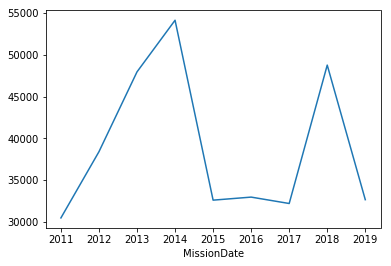

In [34]:
annual_removals.plot()

In [35]:
annual_transfers

MissionDate
2010-10-01    10605
2011-10-01    16162
2012-10-01    16707
2013-10-01    15124
2014-10-01     6556
2015-10-01     8069
2016-10-01     8878
2017-10-01    10373
2018-10-01     8094
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [36]:
annual_juvenile_removals

MissionDate
2010-10-01    330.0
2011-10-01    251.0
2012-10-01    229.0
2013-10-01    149.0
2014-10-01     92.0
2015-10-01    160.0
2016-10-01    226.0
2017-10-01    363.0
2018-10-01    274.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [37]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [38]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
4255,2019-04-24,GUATEMALA,R,KIWA,MGGT,132,1,2.0,0.015152,93.0,70.454545
4256,2019-04-24,GUATEMALA,R,KBRO,MGGT,169,2,0.0,0.000000,168.0,99.408284
4257,2019-04-25,GUATEMALA,R,KAEX,MGGT,104,1,0.0,0.000000,52.0,50.000000
4258,2019-04-25,GUATEMALA,R,KELP,MGGT,129,1,2.0,0.015504,49.0,37.984496
4259,2019-04-25,GUATEMALA,R,KIAH,MGGT,76,1,0.0,0.000000,29.0,38.157895
4260,2019-04-25,GUATEMALA,R,KIWA,MGGT,115,1,0.0,0.000000,98.0,85.217391
4261,2019-04-25,GUATEMALA,R,KBRO,MGGT,56,1,0.0,0.000000,54.0,96.428571
4262,2019-04-26,GUATEMALA,R,KIWA,MGGT,252,2,1.0,0.003968,190.0,75.396825
4263,2019-04-26,GUATEMALA,R,KBRO,MGGT,259,2,0.0,0.000000,244.0,94.208494
4264,2019-04-30,GUATEMALA,R,KCSG,MGGT,67,1,0.0,0.000000,51.0,76.119403


In [39]:
removals.to_csv(f'../output/{nationality}_removal_flights.csv')

In [40]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-10-01,GUATEMALA,T,KDEN,KIWA,3,1,0.0,0.0,0.0,0.0
1,2010-10-01,GUATEMALA,T,KMCI,KAEX,6,1,0.0,0.0,0.0,0.0
2,2010-10-01,GUATEMALA,T,KMDT,KAEX,18,1,0.0,0.0,0.0,0.0
3,2010-10-01,GUATEMALA,T,KOAK,KIWA,2,1,0.0,0.0,0.0,0.0
4,2010-10-01,GUATEMALA,T,KOAK,KSAN,3,1,0.0,0.0,0.0,0.0


In [41]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [42]:
removals.set_index('MissionDate', inplace=True)

In [43]:
transfers.set_index('MissionDate', inplace=True)

In [44]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

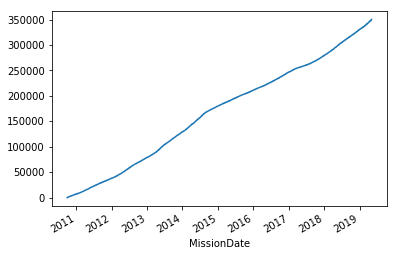

In [45]:
# Cumulative removals
# Based on density of removals, decide whether to use points or line
# r_cum.plot(style='o-')
r_cum.plot(style='-')

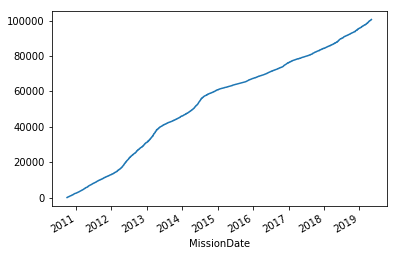

In [46]:
# Cumulative transfers
t_cum.plot()

In [47]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [48]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [49]:
removal_dropoff_airports.head()

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
7,2010-10-01,R,Phoenix-Mesa-Gateway Airport,La Aurora Airport,Guatemala,10723,104
0,2010-10-01,R,Alexandria International Airport,La Aurora Airport,Guatemala,6091,53
8,2010-10-01,R,San Antonio International Airport,La Aurora Airport,Guatemala,4922,68
6,2010-10-01,R,Miami International Airport,La Aurora Airport,Guatemala,2078,53
9,2010-10-01,R,Valley International Airport,La Aurora Airport,Guatemala,2041,41


In [50]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
34,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,2327,85
93,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,1644,95
57,2010-10-01,T,Metropolitan Oakland International Airport,Phoenix-Mesa-Gateway Airport,USA,592,170
94,2010-10-01,T,Toledo Express Airport,Alexandria International Airport,USA,568,48
21,2010-10-01,T,Chicago O'Hare International Airport,Alexandria International Airport,USA,445,50
29,2010-10-01,T,El Paso International Airport,Phoenix-Mesa-Gateway Airport,USA,427,36
31,2010-10-01,T,Eppley Airfield,Alexandria International Airport,USA,403,34
19,2010-10-01,T,Boeing Field King County International Airport,Phoenix-Mesa-Gateway Airport,USA,331,27
67,2010-10-01,T,Ontario International Airport,Phoenix-Mesa-Gateway Airport,USA,327,7
45,2010-10-01,T,Kansas City International Airport,Alexandria International Airport,USA,295,50


In [51]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [52]:
removal_dropoff_airports = removal_dropoff_airports.set_index('MissionDate')

In [53]:
removal_sum = removal_dropoff_airports.groupby([pd.Grouper(freq='AS-OCT'), 'air2_AirportName'])[['AlienMasterID']].sum()

In [54]:
removal_sum.reset_index(inplace=True)
removal_sum = removal_sum.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False])

In [55]:
removal_sum.set_index('MissionDate', inplace=True)

In [56]:
removal_sum = removal_sum.dropna()

In [57]:
top_5_df = pd.DataFrame()

for year in removal_sum.index.unique():
    temp = removal_sum.loc[f'{year}'][['air2_AirportName', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['air2_AirportName', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

/Users/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [58]:
top_5_df

,0,air2_AirportName,AlienMasterID
air2_AirportName,La Aurora Airport,NaN,NaN
AlienMasterID,30472,NaN,NaN
2010-10-01 00:00:00,NaN,ALL OTHERS,0.0
2011-10-01 00:00:00,NaN,La Aurora Airport,38229.0
2011-10-01 00:00:00,NaN,San Antonio International Airport,120.0
2011-10-01 00:00:00,NaN,Phoenix-Mesa-Gateway Airport,21.0
2011-10-01 00:00:00,NaN,Miami International Airport,14.0
2011-10-01 00:00:00,NaN,Laredo International Airport,10.0
2011-10-01 00:00:00,NaN,ALL OTHERS,5.0
2012-10-01 00:00:00,NaN,La Aurora Airport,47818.0


In [59]:
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

AttributeError: 'Index' object has no attribute 'year'

In [ ]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='air2_AirportName',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]
pivot.columns = pivot.columns.str.title()
pivot.columns.name = 'Drop-off Airport'

In [ ]:
def airport_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

In [ ]:
airport_trend(pivot,
              title=f'{nationality.title()} \n Top Dropoff Airports for Removals',
              filename=f'{nationality}_top_removal_airports',
              ylabel='Total Removals',
              xlabel='Fiscal Year');

## Juveniles only

In [60]:
removals['JuvenileCount'].resample('AS-OCT').sum()

MissionDate
2010-10-01    330.0
2011-10-01    251.0
2012-10-01    229.0
2013-10-01    149.0
2014-10-01     92.0
2015-10-01    160.0
2016-10-01    226.0
2017-10-01    363.0
2018-10-01    274.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [61]:
juv_r_cum = removals['JuvenileCount'].cumsum()

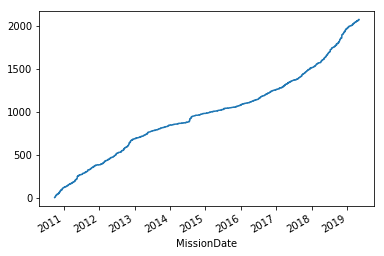

In [62]:
juv_r_cum.plot()

In [63]:
removals.tail(20)

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2019-04-24,GUATEMALA,R,KIWA,MGGT,132,1,2.0,0.015152,93.0,70.454545
2019-04-24,GUATEMALA,R,KBRO,MGGT,169,2,0.0,0.000000,168.0,99.408284
2019-04-25,GUATEMALA,R,KAEX,MGGT,104,1,0.0,0.000000,52.0,50.000000
2019-04-25,GUATEMALA,R,KELP,MGGT,129,1,2.0,0.015504,49.0,37.984496
2019-04-25,GUATEMALA,R,KIAH,MGGT,76,1,0.0,0.000000,29.0,38.157895
2019-04-25,GUATEMALA,R,KIWA,MGGT,115,1,0.0,0.000000,98.0,85.217391
2019-04-25,GUATEMALA,R,KBRO,MGGT,56,1,0.0,0.000000,54.0,96.428571
2019-04-26,GUATEMALA,R,KIWA,MGGT,252,2,1.0,0.003968,190.0,75.396825
2019-04-26,GUATEMALA,R,KBRO,MGGT,259,2,0.0,0.000000,244.0,94.208494


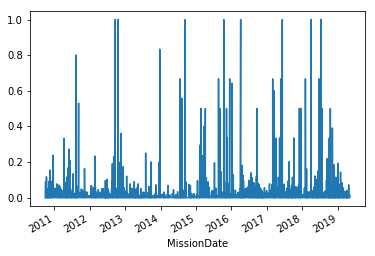

In [64]:
removals['JuvPercent'].plot();

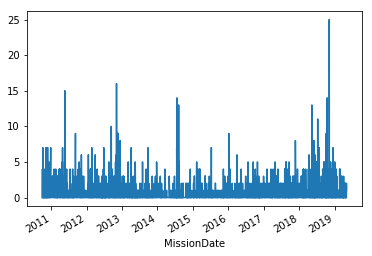

In [65]:
removals['JuvenileCount'].plot();

In [66]:
removals[removals['JuvPercent'] > .5]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2011-08-11,GUATEMALA,R,KSAT,MGGT,5,1,4.0,0.800000,5.0,100.000000
2011-09-09,GUATEMALA,R,KHRL,MGGT,17,1,9.0,0.529412,17.0,100.000000
2012-09-20,GUATEMALA,R,KMIA,MGGT,1,1,1.0,1.000000,1.0,100.000000
2012-10-18,GUATEMALA,R,KMIA,MGGT,3,1,3.0,1.000000,3.0,100.000000
2013-12-23,GUATEMALA,R,KBRO,MGGT,6,1,5.0,0.833333,6.0,100.000000
2014-07-18,GUATEMALA,R,KROW,MGGT,12,1,7.0,0.583333,12.0,100.000000
2014-07-22,GUATEMALA,R,KROW,MGGT,21,1,14.0,0.666667,21.0,100.000000
2014-07-24,GUATEMALA,R,KROW,MGGT,21,1,12.0,0.571429,21.0,100.000000
2014-08-07,GUATEMALA,R,KROW,MGGT,24,1,13.0,0.541667,24.0,100.000000


In [67]:
transfers['JuvenileCount'].value_counts()

0.0     8853
1.0      153
2.0       60
5.0       53
3.0       52
4.0       50
6.0       44
7.0       41
8.0       39
12.0      35
10.0      35
11.0      32
9.0       32
13.0      23
17.0      14
14.0      14
15.0      12
20.0      10
18.0      10
21.0       8
16.0       8
25.0       8
23.0       6
19.0       6
34.0       5
26.0       5
24.0       4
35.0       4
36.0       4
42.0       4
39.0       3
38.0       3
22.0       3
40.0       2
46.0       2
54.0       2
32.0       2
65.0       2
33.0       2
28.0       2
29.0       1
27.0       1
50.0       1
43.0       1
49.0       1
30.0       1
37.0       1
47.0       1
31.0       1
Name: JuvenileCount, dtype: int64

In [70]:
removals[removals['JuvenileCount'] > 20]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,


# KBFI only

In [130]:
airport = 'KBFI'

In [131]:
airport_removals = pd.concat([removals[removals['PULOC'] == airport], removals[removals['DropLoc'] == airport]])

In [132]:
airport_removals

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2010-10-02,MEXICO,R,KBFI,KSAN,53,1,0.0,0.000000,0.0,0.000000
2010-10-06,MEXICO,R,KBFI,KHRL,18,1,0.0,0.000000,0.0,0.000000
2010-10-09,MEXICO,R,KBFI,KSAN,63,1,0.0,0.000000,0.0,0.000000
2010-10-13,MEXICO,R,KBFI,KHRL,27,1,0.0,0.000000,0.0,0.000000
2010-10-16,MEXICO,R,KBFI,KSAN,47,1,1.0,0.021277,0.0,0.000000
2010-10-23,MEXICO,R,KBFI,KSAN,99,1,0.0,0.000000,0.0,0.000000
2010-10-27,MEXICO,R,KBFI,KHRL,20,1,0.0,0.000000,0.0,0.000000
2010-10-30,MEXICO,R,KBFI,KSAN,92,1,0.0,0.000000,0.0,0.000000
2010-11-03,MEXICO,R,KBFI,KHRL,47,1,0.0,0.000000,0.0,0.000000


In [133]:
airport_transfers = pd.concat([transfers[transfers['PULOC'] == airport], transfers[transfers['DropLoc'] == airport]])

In [134]:
airport_transfers.to_csv(f'../output/{nationality}_transfers_tofrom_{airport}.csv')

In [135]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [136]:
airport_annual_removals

MissionDate
2010-10-01    62
2011-10-01    56
2012-10-01    40
2013-10-01    20
2014-10-01    15
2015-10-01    12
2016-10-01    14
2017-10-01    25
2018-10-01     8
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [137]:
airport_annual_removal_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [138]:
airport_annual_juvenile_removals

MissionDate
2010-10-01    13.0
2011-10-01     8.0
2012-10-01     2.0
2013-10-01     0.0
2014-10-01     0.0
2015-10-01     0.0
2016-10-01     0.0
2017-10-01     4.0
2018-10-01     0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [139]:
airport_annual_transfers

MissionDate
2010-10-01    14
2011-10-01    13
2012-10-01    32
2013-10-01    46
2014-10-01    34
2015-10-01    40
2016-10-01    40
2017-10-01    43
2018-10-01     7
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [140]:
airport_annual_transfer_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [141]:
airport_annual_juvenile_transfers

MissionDate
2010-10-01    0.0
2011-10-01    0.0
2012-10-01    0.0
2013-10-01    4.0
2014-10-01    0.0
2015-10-01    0.0
2016-10-01    0.0
2017-10-01    0.0
2018-10-01    0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64